# Diagramme für Projekt ZEnsys

## python konfigurieren

### Module importieren

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import datetime as dt
import seaborn as sns
from distutils.spawn import find_executable
from cycler import cycler
from collections.abc import Iterable
from sklearn import linear_model
from jupytercards import display_flashcards
from pygit2 import Repository
from jupyterquiz import display_quiz

print('Versionen der verwendeten python-Module: ')
print('numpy', np.__version__)
print('matplotlib', matplotlib.__version__)
print('pandas', pd.__version__)
print('datetime', dt)
print('seaborn', sns.__version__)
print('find_executable',find_executable)
print('cycler',cycler)

Versionen der verwendeten python-Module: 
numpy 1.24.2
matplotlib 3.7.1
pandas 1.5.3
datetime <module 'datetime' from '/home/franzi/.pyenv/versions/miniconda3-latest/envs/sen/lib/python3.10/datetime.py'>
seaborn 0.12.2
find_executable <function find_executable at 0x7fcfb2bfdea0>
cycler <function cycler at 0x7fd002b41bd0>


### Grafikparameter einstellen

In [2]:
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 54
plt.rcParams['axes.titlesize'] = 54
plt.rcParams['font.size'] = 54
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 54
plt.rcParams['xtick.labelsize'] = 48
plt.rcParams['ytick.labelsize'] = 48

if find_executable('latex'):
    plt.rcParams['text.usetex'] = True
    pd.set_option('display.latex.repr', True)
    pd.set_option('display.latex.longtable', True)

### Funktionen definieren

Das zu verwendende Farbschema, angelehnt an [farbenblindenfreundlichen Farben](https://personal.sron.nl/~pault/#sec:qualitative), kann über eine der im folgenden gelisteten Einstellungen gewählt werden:

In [3]:
# define different color schemes according to:
# https://personal.sron.nl/~pault/#sec:qualitative

BRIGHT = ['#4477aa', '#66ccee', '#228833', '#ccbb44',
          '#ee6677', '#aa3377', '#bbbbbb']

HIGH_CONTRAST = ['#ffffff', '#ddaa33', '#bb5566', '#004488',
                 '#000000']

VIBRANT = ['#0077bb', '#33bbee', '#009988', '#ee7733',
          '#cc3311', '#ee3377', '#bbbbbb']

MUTED = ['#332288', '#88ccee', '#44aa99', '#117733',
         '#999933', '#ddcc77', '#cc6677', '#882255', '#aa4499',
         '#dddddd']

MEDIUM_CONTRAST = ['#ffffff', '#eecc66', '#ee99aa', '#6699cc',
                   '#997700', '#994455', '#004488', '#000000']

LIGHT = ['#77aadd', '#99ddff', '#44bb99', '#bbcc33',
         '#aaaa00', '#eedd88', '#ee8866', '#ffaabb', '#dddddd']

ALL_SCHEMES_KEYS = ['BRIGHT',
               'HIGH_CONTRAST',
               'VIBRANT',
               'MUTED',
               'MEDIUM_CONTRAST',
               'LIGHT']

ALL_SCHEMES_VALS = [BRIGHT,
                    HIGH_CONTRAST,
                    VIBRANT,
                    MUTED,
                    MEDIUM_CONTRAST,
                    LIGHT]

ALL_SCHEMES_DICT = dict(zip(ALL_SCHEMES_KEYS, ALL_SCHEMES_VALS))

def set_colors(scheme):
    if scheme not in ALL_SCHEMES_KEYS:
        raise ValueError(f"scheme not spported yet, needs to be either of\n\
        {[name for name in ALL_SCHEMES_KEYS]}")
    rcParams['axes.prop_cycle'] = cycler('color', ALL_SCHEMES_DICT[scheme])

In [4]:
set_colors('BRIGHT')

Die folgende Funktion ermöglicht es, die Achsenskalierung besser anzupassen.

In [5]:
class AxTransformer:
    def __init__(self, datetime_vals=False):
        self.datetime_vals = datetime_vals
        self.lr = linear_model.LinearRegression()
        
        return
    
    def process_tick_vals(self, tick_vals):
        if not isinstance(tick_vals, Iterable) or isinstance(tick_vals, str):
            tick_vals = [tick_vals]
            
        if self.datetime_vals == True:
            tick_vals = pd.to_datetime(tick_vals).astype(int).values
            
        tick_vals = np.array(tick_vals)
            
        return tick_vals
    
    def fit(self, ax, axis='x'):
        axis = getattr(ax, f'get_{axis}axis')()
        
        tick_locs = axis.get_ticklocs()
        tick_vals = self.process_tick_vals([label._text for label in axis.get_ticklabels()])
        
        self.lr.fit(tick_vals.reshape(-1, 1), tick_locs)
        
        return
    
    def transform(self, tick_vals):        
        tick_vals = self.process_tick_vals(tick_vals)
        tick_locs = self.lr.predict(np.array(tick_vals).reshape(-1, 1))
        
        return tick_locs
    
def set_date_ticks(ax, start_date, end_date, axis='y', date_format='%Y-%m-%d', **date_range_kwargs):
    dt_rng = pd.date_range(start_date, end_date, **date_range_kwargs)

    ax_transformer = AxTransformer(datetime_vals=True)
    ax_transformer.fit(ax, axis=axis)
    
    getattr(ax, f'set_{axis}ticks')(ax_transformer.transform(dt_rng))
    getattr(ax, f'set_{axis}ticklabels')(dt_rng.strftime(date_format))

    ax.tick_params(axis=axis, which='both', bottom=True, top=False, labelbottom=True)
    
    return ax

## Daten laden

In [6]:
df = pd.read_csv('../data/household_data_1min_singleindex.csv')

zu finden unter: https://data.open-power-system-data.org/household_data/2020-04-15 {cite:p}`minde_household_2017`

## Datumswerte konvertieren

In [7]:
print(df.utc_timestamp.head())

0    2015-10-26T12:31:00Z
1    2015-10-26T12:32:00Z
2    2015-10-26T12:33:00Z
3    2015-10-26T12:34:00Z
4    2015-10-26T12:35:00Z
Name: utc_timestamp, dtype: object


Format `%Y-%m-%dT%H%M%SZ` laut Readme

In [8]:
df['zeit'] = df.utc_timestamp.apply(#
    lambda x: #
    dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
print(df['zeit'].head())

0   2015-10-26 12:31:00
1   2015-10-26 12:32:00
2   2015-10-26 12:33:00
3   2015-10-26 12:34:00
4   2015-10-26 12:35:00
Name: zeit, dtype: datetime64[ns]


## Daten in einem Diagramm darstellen

In [9]:
df.head()

/home/franzi/.pyenv/versions/miniconda3-latest/envs/sen/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return method()


utc_timestamp        cet_cest_timestamp  \
0  2015-10-26T12:31:00Z  2015-10-26T13:31:00+0100   
1  2015-10-26T12:32:00Z  2015-10-26T13:32:00+0100   
2  2015-10-26T12:33:00Z  2015-10-26T13:33:00+0100   
3  2015-10-26T12:34:00Z  2015-10-26T13:34:00+0100   
4  2015-10-26T12:35:00Z  2015-10-26T13:35:00+0100   

   DE_KN_industrial1_grid_import  DE_KN_industrial1_pv_1  \
0                            NaN                     NaN   
1                            NaN                     NaN   
2                            NaN                     NaN   
3                            NaN                     NaN   
4                            NaN                     NaN   

   DE_KN_industrial1_pv_2  DE_KN_industrial2_grid_import  \
0                     NaN                            NaN   
1                     NaN                            NaN   
2                     NaN                            NaN   
3                     NaN                            NaN   
4                     NaN                            NaN   

   DE_KN_industrial2_pv_1  DE_KN_industrial2_storage_charge  \
0                     NaN                               NaN   
1                     NaN                               NaN   
2                     NaN                               NaN   
3                     NaN                               NaN   
4                     NaN                               NaN   

   DE_KN_industrial2_storage_decharge  DE_KN_industrial3_area_offices  ...  \
0                                 NaN                             NaN  ...   
1                                 NaN                             NaN  ...   
2                                 NaN                             NaN  ...   
3                                 NaN                             NaN  ...   
4                                 NaN                             NaN  ...   

   DE_KN_residential5_washing_machine  DE_KN_residential6_circulation_pump  \
0                                 NaN                                  NaN   
1                                 NaN                                  NaN   
2                                 0.0                                  NaN   
3                                 0.0                                  NaN   
4                                 0.0                                  NaN   

   DE_KN_residential6_dishwasher  DE_KN_residential6_freezer  \
0                            NaN                         NaN   
1                            NaN                         NaN   
2                            NaN                         NaN   
3                            NaN                         NaN   
4                            NaN                         NaN   

   DE_KN_residential6_grid_export  DE_KN_residential6_grid_import  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3                             NaN                             NaN   
4                             NaN                             NaN   

   DE_KN_residential6_pv  DE_KN_residential6_washing_machine  \
0                    NaN                                 NaN   
1                    NaN                                 NaN   
2                    NaN                                 NaN   
3                    NaN                                 NaN   
4                    NaN                                 NaN   

   interpolated_values                zeit  
0                  NaN 2015-10-26 12:31:00  
1                  NaN 2015-10-26 12:32:00  
2                  NaN 2015-10-26 12:33:00  
3                  NaN 2015-10-26 12:34:00  
4                  NaN 2015-10-26 12:35:00  

[5 rows x 73 columns]

## Energiedaten in Leistungswerte umrechnen

In [38]:
df.rename(columns = {'DE_KN_industrial1_pv_1':'PVenergy'}, inplace = True)
df['PV'] = df['PVenergy'].diff()
df['Hausenergy'] = df['DE_KN_residential6_grid_import']-df['DE_KN_residential6_grid_export']+df['DE_KN_residential6_pv']
df['Haus'] = df['Hausenergy'].diff()

wobei die y-Achsenbeschriftung noch fehlt: aus dem [Readme des Datensatzes](https://data.open-power-system-data.org/household_data/2017-11-10/README.md) ergibt sich die Energieeinheit zu kWh

x-Achse müsste Anzahl der Werte bezogen auf die Auflösung ergeben

In [11]:
res = df['zeit'][1]-df['zeit'][0]
print('Auflösung '+str(res))

Auflösung 0 days 00:01:00


d.h. die y-Achse hat momentan die Einheit $[dW/dt] = 1\text{ kWh/min.}$ 

In [12]:
dW = 1000*60*60 # kWh in J
dt = 60 # min. in sec
dW_dt_faktor = dW/dt
print('Umrechnungsfaktor zu W ist ' + str(dW_dt_faktor))

Umrechnungsfaktor zu W ist 60000.0


In [39]:
df['PV'] = dW_dt_faktor*0.001*df['PVenergy'].diff()
df['Haus'] = dW_dt_faktor*0.001*df['Hausenergy'].diff()

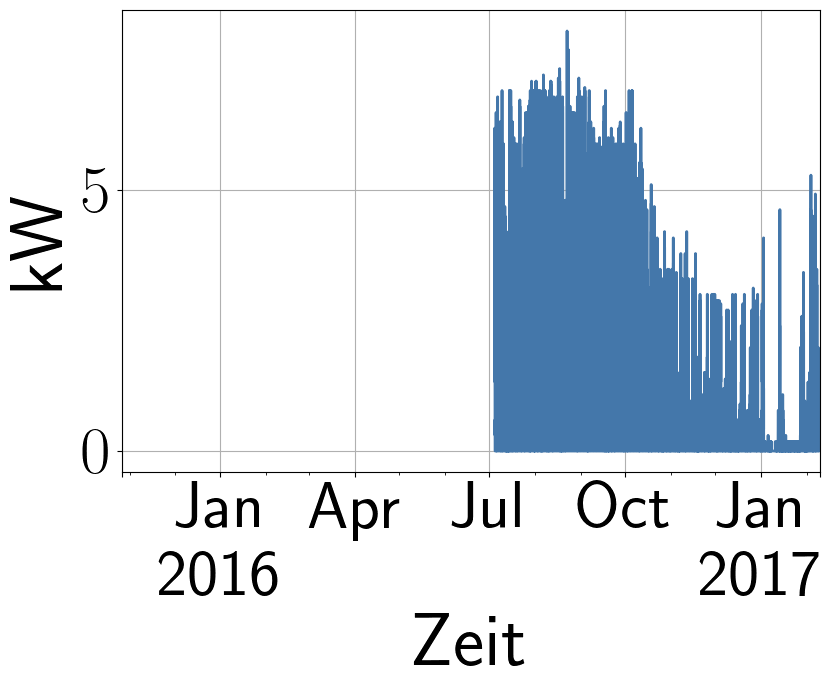

In [20]:
df.plot(x = 'zeit', y = 'PV', figsize=(9,6), legend=False)
plt.xlabel('Zeit')
plt.ylabel('kW');
plt.grid()
plt.show()

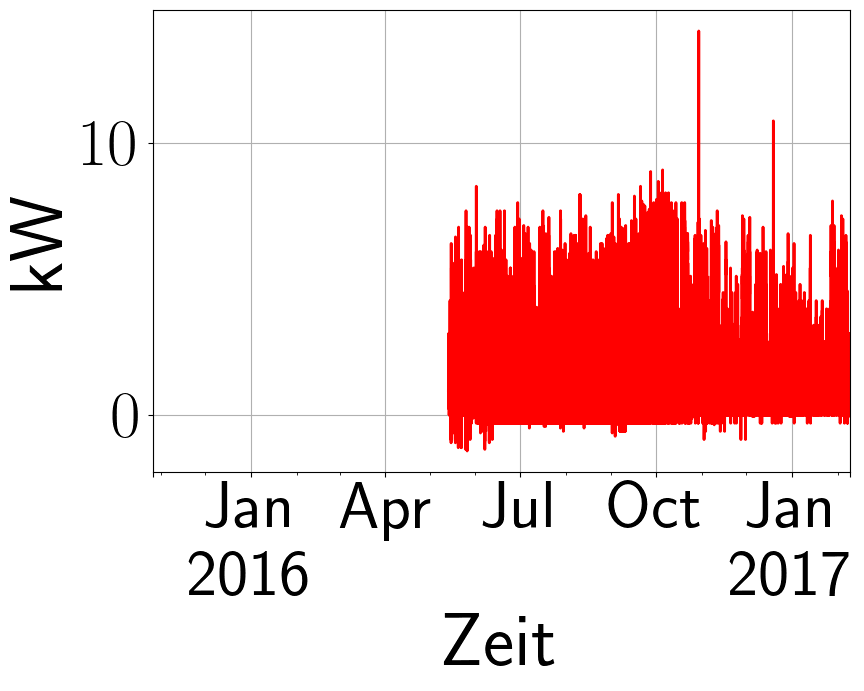

In [41]:
df.plot(x = 'zeit', y = 'Haus', figsize=(9,6), legend=False, color='r')
plt.xlabel('Zeit')
plt.ylabel('kW');
plt.grid()
plt.show()

## Degradation

Text(0, 0.5, 'Degradation')

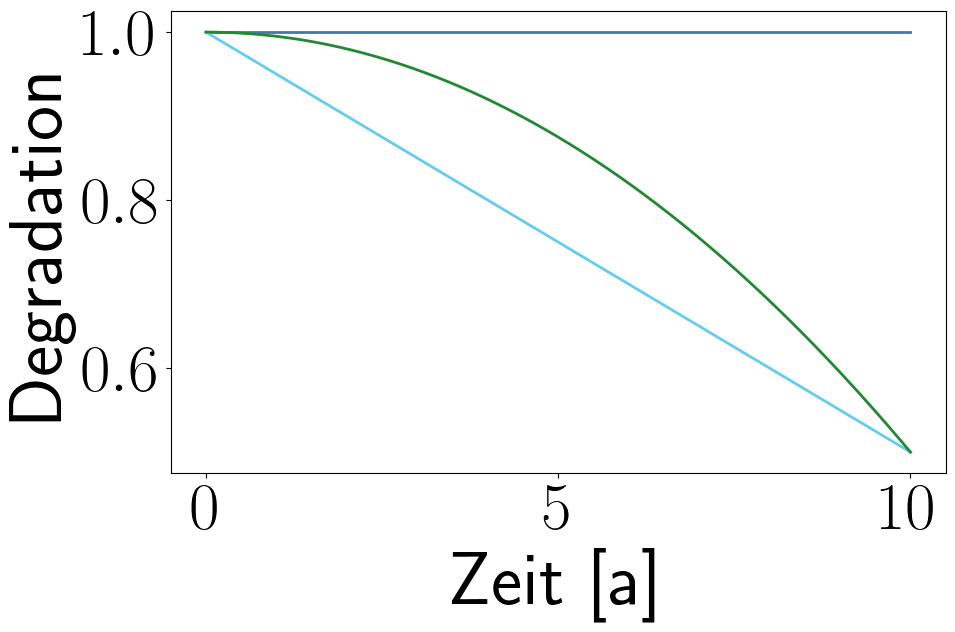

In [33]:
tim = np.linspace(0,10,1000)
nodeg = np.ones(len(tim))
lindeg = nodeg*(1-tim*0.05) # phantasy value
curvedeg = nodeg*(1-0.005*tim**2) # phantasy value
plt.plot(tim,nodeg)
plt.plot(tim,lindeg)
plt.plot(tim,curvedeg)
plt.xlabel('Zeit [a]')
plt.ylabel('Degradation')

## Ausfallrate

noch bauen

## Wirkungsgrad

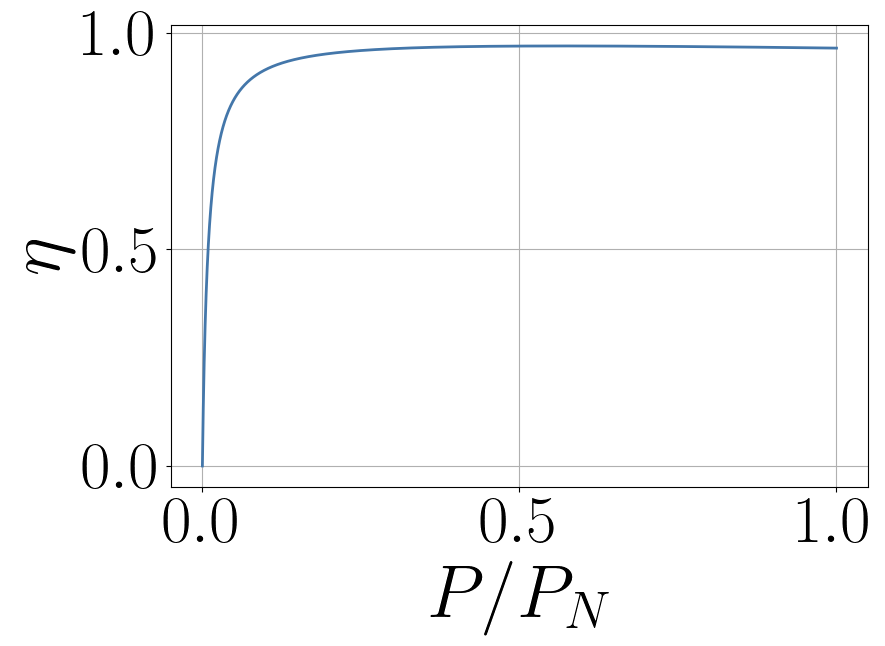

In [37]:
I2N = 10 # 10 A Nennstrom auf Sekundärseite
I2 = np.linspace(0,I2N,10000) # Strom auf Sekundärseite
x = I2/I2N
plt.figure(figsize=(9,6))
eta1 = (230-6*x)*87*x/((230-6*x)*87*x+180+540*x**2)
eta2 = (230-12*x)*87*x*0.8/((230-12*x)*87*x*0.8+180+540*x**2)
plt.plot(I2/np.max(I2),eta1,label=r'$\eta_1$ $(\cos\varphi=1)$')
#plt.plot(I2,eta2,label=r'$\eta_2$ $(\cos\varphi=0.8)$')
#plt.legend(loc='best')
plt.xlabel(r'$P/P_N$')
plt.ylabel(r'$\eta$')
plt.grid()
plt.show()

## Energiedaten darstellen in jupyter notebook

nach {cite:p}`walker_tutorial_2019`

### Spalten für Jahr, Monat, Tag, etc. einfügen

In [15]:
df['Jahr'] = df['zeit'].dt.year
df['Monat'] = df['zeit'].dt.month
df['Wochentag'] = df['zeit'].dt.weekday

In [16]:
# df.sample(5)

## Stromlastprofil eines Industrieunternehmens

In [17]:
df['industrialP'] = df['industrial'].diff()

KeyError: 'industrial'

In [ ]:
df.plot(x='zeit',y='industrialP', figsize=(9,6))
plt.grid()
plt.show()

wobei die y-Achsenbeschriftung noch fehlt: aus dem [Readme des Datensatzes](https://data.open-power-system-data.org/household_data/2017-11-10/README.md) ergibt sich die Energieeinheit zu kWh

x-Achse müsste Anzahl der Werte bezogen auf die Auflösung ergeben

In [ ]:
res = df['zeit'][1]-df['zeit'][0]
print('Auflösung '+str(res))

d.h. die y-Achse hat momentan die Einheit $[dW/dt] = 1\text{ kWh/min.}$ 

In [ ]:
dW = 1000*60*60 # kWh in J
dt = 60 # min. in sec
dW_dt_faktor = dW/dt
print('Umrechnungsfaktor zu W ist ' + str(dW_dt_faktor))

besser ist also, das gleich richtig zu berechnen:

In [ ]:
df['industrialP'] = dW_dt_faktor*0.001*df['industrial'].diff()

In [ ]:
df.plot(x='zeit',y='industrialP', figsize=(9,6))
plt.ylabel('Leistung [kW]')
plt.grid()
plt.show()

Schwer zu lesen mit so vielen Datenpunkten und leider ist die x-Achse voll mit fehlenden Daten.
Die Achse wird nicht gut ausgenutzt.

Fehlende Werte (`NaN`) weglassen:

In [ ]:
df2 = df.dropna(subset=['zeit','industrialP'])

In [ ]:
df2.plot(x='zeit',y='industrialP', style='.', figsize=(9,6))
plt.ylabel('Leistung [kW]')
plt.grid()
plt.show()

## Dauerlinie

In [ ]:
sorted_industrial = sorted(df2['industrialP'], reverse = True)

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(df2.index-df2.index[0],sorted_industrial)
plt.ylabel('Leistung [kW]')
plt.grid()
plt.show()

Was sehen wir hier?

zum Vergleich: Minuten in einem Jahr:

In [ ]:
no_min_year = 365*24*60
print(no_min_year)

Eine Dauerlinie hat meist drei Bereiche mit Hinweisen für rationellere Energieverwendung:
1. Spitzenlasten, die verschoben werden können
2. unnötige Standby-Verbräuche
3. den mittleren Bereich

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(df2.index-df2.index[0],sorted_industrial)
plt.xlabel('Anzahl Minuten')
plt.ylabel('Leistung [kW]')
plt.text(10000,300,'Spitzenlastverschiebung', fontsize=15)
plt.text(80000,120,'allgemein effizientere Prozesse', fontsize=15)
plt.text(210000,60,'Standby reduzieren', fontsize=15)
plt.grid()
plt.show()

In [ ]:
repository_name = Repository('.').head.shorthand  # gibt den Namen des aktuellen repo wieder

quiz_main_path = 'https://gitlab.com/oer4renewables/systemtechnik-fuer-energieeffizienz/-/raw/' + repository_name + '/files/quiz/'
quiz_name = '2_2_Erste_Energiedatenanalyse.json'

display_quiz(quiz_main_path + quiz_name)

## Vergleich mit lokaler Solarerzeugung

In [ ]:
df.rename(columns = {'DE_KN_industrial1_pv_1':'pv'}, inplace = True)
df['pvP'] = dW_dt_faktor*0.001*df['pv'].diff()
df2 = df.dropna(subset=['zeit','industrialP','pvP'])

axes = df2.plot(x = 'zeit', y= ['industrialP','pvP'], marker='.',#
                         alpha=0.5, linestyle='None',#
                         figsize=(11,5), subplots=True, grid=True)
for ax in axes:
    ax.set_ylabel('Leistung [kW]')

<div class="admonition important" style="background: #e9f6ec; padding: 10px">
<div class="title"><b>AUFGABE</b></div>
Was sehen Sie? Was fällt auf?
</div>

*Antwort:...*

## Stromlastprofil Januar 2017 genauer ansehen

erst mal als Index den Zeitstempel einstellen

In [ ]:
df2.set_index('zeit', inplace = True)

In [ ]:
ax = df2.loc['2017-1'].plot(y = 'industrialP',linestyle='-', figsize=(9,6))
plt.ylabel('Leistung [kW]')
plt.grid()
plt.show()

höchster Stromverbrauch an Wochentagen und niedrigster unter der Woche?

### Wochentage aus matplotlib

In [ ]:
import matplotlib.dates as mdates

### Wöchentliches Gitter im Diagramm

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(df2.loc['2017-1', 'industrialP'], linestyle='-')
ax.set_ylabel('Leistung [kW]')
ax.set_title('Strombedarf Januar 2017')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%b'))
plt.grid()
plt.show()

hier scheint auch sonntags ein erhöhter Bedarf zu sein - das kann man hinterfragen, wenn man den Betrieb kennt und herausfinden, ob z. B. sonntags gearbeitet wird

## Jahreszeitliche Schwankungen mit Boxplots

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

for name, ax in zip(['industrialP', 'pvP'], axes):
    ax.grid()
    sns.boxplot(data=df2, x='Monat', y=name, ax=ax)
if ax != axes[-1]:
    ax.set_xlabel('')

Über einige Monate lässt sich keine Aussage treffen, aufgrund fehlender Daten.

Die Solarerzeugung ist naturgemäß im Sommer höher als im Winter. Das ist plausibel.

Falls mehr Solarfläche vorhanden wäre (z. B. weitere Dachflächen, Fassaden, ggf. auch gemietet), könnte der Anteil lokaler Erzeugung erhöht werden.

Schön ist, dass im Sommer offenbar auch ein höherer Bedarf besteht, so dass eine erhöhte Solarerzeugung diesen auch verringern könnte.

## Wochentagsabhängigkeit des Lastprofils

In [ ]:
plt.figure(figsize=(9,6))
sns.boxplot(data = df2, x = 'Wochentag', y= 'industrialP');
plt.grid()

Hier sieht man, dass der Verbrauch deutlich geringer ist am Wochenende, dass es aber ein paar extreme Leistungswerte dann gibt. D.h. entweder geschieht dann ein Hochlauf mit hohem Bedarf oder es handelt sich um vermeidbare Leistungswerte.

## Gleitende Mittelwerte bilden: Fensterung von Daten (*Windowing*)

Im Fenster wird z. B. der Mittelwert gebildet, dann bewegt sich das Fenster einen Wert weiter, es wird
wieder ein Mittelwert gebildet etc.

Beispiel anhand von Zufallszahlen: 

In [ ]:
dfr = pd.DataFrame(np.random.rand(100), columns = ["Zahlen"])

In [ ]:
dfr["rollierend3"] = dfr["Zahlen"].rolling(window=3, center=True).mean()
dfr["rollierend9"] = dfr["Zahlen"].rolling(window=9, center=True).mean()
dfr["rollierend27"] = dfr["Zahlen"].rolling(window=27, center=True).mean()

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(dfr.loc[:, 'Zahlen'],
marker='.', linestyle='-', linewidth=0.5, label='Zahlen')
ax.plot(dfr.loc[:, 'rollierend3'],
marker='o', markersize=2, linestyle='-', label='Fensterbreite=3')
ax.plot(dfr.loc[:, 'rollierend9'],
marker='o', markersize=3, linewidth =2,linestyle='-', label='Fensterbreite=9')
ax.plot(dfr.loc[:, 'rollierend27'],
marker='o', markersize=4, linewidth =3,linestyle='-', label='Fensterbreite=27')
ax.set_ylabel('Zufallszahlen')
ax.legend()
plt.grid()
plt.show()

Je größer das Fenster ``window`` gewählt ist, desto mehr benachbarte Werte werden zur Berechnung des Mittelwerts ``mean`` herangezogen. Dies resultiert in einer besseren Glättung. In dem folgenden Bild ist ein Beispiel für 10 Zufallszahlen und eine Fensterbreite von 3 gegeben.

![Windowing](../img/Windowing.jpg)

Jetzt geht es weiter mit den Energiedaten:

In [ ]:
df2_1d = df2['industrialP'].rolling(24*60, center=True).mean()

Fensterungsergebnis, wöchentlicher Mittelwert und Tageswert im Vergleich

In [ ]:
start, end = '2017-01', '2017-02'
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df2.loc[start:end, 'industrialP'], 
       marker = '.', linestyle = '-', linewidth = 0.5,
        label = 'minute')
ax.plot(df2_1d.loc[start:end],
       marker = '.', linestyle = '-', linewidth = 0.5,
        label = 'daily')
ax.set_ylabel('Leistung [kW]')
ax.legend()
ax.grid()

Ergebnis der Glättung der Daten mithilfe einer Fensterung mit einem Rechteckfenster
bzw. dem rollierenden Mittelwert

Fensterungsergebnis hat die gleiche Auflösung wie das ursprüngliche Datenset, aber ist etwas geglättet

Hier kann man Trends und Wiederholungseffekte besser erkennen.

Manchmal sind Datensätze auch sehr hochaufgelöst (für non-intrusive load monitoring, NILM), dann muss man die erst [verkleinern](highres-downsample) (jupyter notebook unter `files/nb/Hochaufgeloeste_Daten_downsamplen.ipynb`). 

## Histogramm der Leistungswerte

In [ ]:
plt.figure(figsize=(9,6))
df2['industrialP'].hist(bins = 50)
plt.show()

Hier ist deutlich zu sehen, welche Leistungswerte besonders häufig vorkommen. Allerdings ist die y-Achsen-Skalierung mit Vorsicht zu genießen ...

## Heatmaps erzeugen

In [ ]:
hm_df = pd.DataFrame({'industrialP': df2['industrialP']})
hm_df['date'] = df2.index.date
hm_df['time'] = df2.index.time
hm_piv = hm_df.pivot(index = 'time', columns = 'date', values = 'industrialP')
fig, ax = plt.subplots(figsize = (10,6))
sns.heatmap(hm_piv, cbar_kws={'label': 'Leistung [kW]'})
ax.set_title('Leistung [kW] des Stromnetzimports\n eines Industriebetriebs')
set_date_ticks(ax, hm_piv.columns[0], hm_piv.columns[-1] ,axis='x', freq='1M', date_format='%B %Y')
ax.tick_params(axis="x", rotation=45)

Es lassen sich hier gewisse Regelmäßigkeiten erkennen: z. B. dass immer wieder dunkle Striche sind, die offenbar im Wochenrhythmus auftreten und suggerieren, dass eine eher geringe Standby-Leistung vorhanden ist. Auch nachts (früh morgens) scheint der Bedarf gering zu sein.

In [ ]:
hm2_df = pd.DataFrame({'pvP': df2['pvP']})
hm2_df['date'] = df2.index.date
hm2_df['time'] = df2.index.time
hm2_piv = hm2_df.pivot(index = 'time', columns = 'date', values = 'pvP')
fig1, ax1 = plt.subplots(figsize = (10,6))
sns.heatmap(hm2_piv, cbar_kws={'label': 'Leistung [kW]'})
ax1.set_title('Leistung [kW] der Photovoltaikerzeugung\n eines Industriebetriebs')
set_date_ticks(ax1, hm2_piv.columns[0], hm2_piv.columns[-1] ,axis='x', freq='1M', date_format='%B %Y')
ax1.tick_params(axis="x", rotation=45)

<div class="admonition important" style="background: #e9f6ec; padding: 10px">
<div class="title"><b>AUFGABE</b></div>
Was sehen Sie? Was fällt auf?
</div>

*Antwort:...*

## Sankey-Diagramme erzeugen

In [ ]:
from matplotlib.sankey import Sankey

fig, ax = plt.subplots(figsize = [6,6])
sankey = Sankey(ax=ax)
sankey.add(flows=[1, -1, 0.5, -0.5],
orientations=[0, 0, 1, -1],
labels=['input', 'output', 'third flow (input)', 'fourth flow (output)'],
rotation=-90)
sankey.finish()
ax.axis('off')
plt.show()

### Formale Anforderungen an ein Sankey-Diagramm

- Breite der Pfeile proportional zur Prozentzahl
- Knotenregel gilt: Summe der Flüsse hinein in ein System muss gleich der Summe der Flüsse hinaus sein
- Flüsse müssen dieselbe Einheit haben, z. B. Energie, Leistung, Material, $CO_2$

### Zum Schmunzeln: ein Sankey-Diagramm ohne Energiebezug

[Wen Trump 2017 auf Twitter am meisten attackierte](https://www.axios.com/who-trump-attacks-the-most-on-twitter-1513305449-f084c32e-fcdf-43a3-8c55-2da84d45db34.html) {cite:p}`kight_who_2017`

```{bibliography}
:filter: docname in docnames
```